2024-10-05 08:01:36.925725: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2400 - val_loss: 0.0776
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0629 - val_loss: 0.0239
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0202 - val_loss: 0.0045
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0063 - val_loss: 0.0030
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0058 - val_loss: 0.0020
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0050 - val_loss: 0.0015
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0035 - val_loss: 0.0016
Epoch 8/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0042 - val_loss: 9.8506e-04
Epoch 9/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0038 - val_loss: 7.4825e-04
Epoch 10/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0032 - val_loss: 5.9034e-04
Epoch 11/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0030 - val_loss: 6.6004e-04
Epoch 12/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss

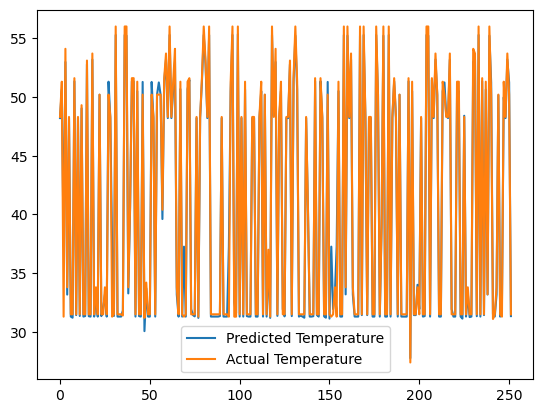

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Load data
data = pd.read_csv('Temp.csv')

# Convert 'DateTime' to datetime format and then to numeric (timestamp)
data['DateTime'] = pd.to_datetime(data['DateTime'], format='mixed', errors='coerce')
data = data.dropna(subset=['DateTime'])  # Drop rows with invalid datetime entries
data['DateTime'] = data['DateTime'].astype(np.int64) // 10**9

# Convert 'Location' and 'AirQualityLevel' to numeric values
label_encoder_location = LabelEncoder()
data['Location'] = label_encoder_location.fit_transform(data['Location'])
label_encoder_aql = LabelEncoder()
data['AirQualityLevel'] = label_encoder_aql.fit_transform(data['AirQualityLevel'])

# Clean 'Temperature' and 'Humidity'
data['Temperature'] = data['Temperature'].str.replace('C', '').astype(float)
data['Humidity'] = data['Humidity'].str.replace('%', '').astype(float)

# Clean other columns
columns_to_clean = ['HeatIndex', 'CO', 'CO2', 'Ethanol', 'NH4', 'Toluene', 'Acetone', 'DustDensity']
for col in columns_to_clean:
    if col in data.columns:
        data[col] = data[col].replace(r'[^\d.]+', '', regex=True).astype(float)

# Handle missing or infinite values
data = data.replace([np.inf, -np.inf], np.nan).dropna()

# Define features
features = ['DateTime', 'Location', 'Longitude', 'Lattitude', 'AirQualityLevel', 
            'Temperature', 'Humidity', 'HeatIndex', 'CO', 'CO2', 
            'Ethanol', 'NH4', 'Toluene', 'Acetone', 'DustDensity']

target = 'Temperature'  # Set temperature as the target variable

X = data[features].values
y = data[target].values.reshape(-1, 1)  # Target to predict

# Apply MinMaxScaler
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y)

# Reshape data into LSTM format
X_lstm = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_scaled, test_size=0.2, random_state=42)

# Build LSTM model
model = Sequential()

# Adding LSTM layers and Dropout to avoid overfitting
model.add(LSTM(64, return_sequences=False, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

# Dense layers for prediction
model.add(Dense(32, activation='relu'))
model.add(Dense(1))  # Single output for the 'Temperature' target

# Compile the model with 'adam' optimizer
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

# Early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

# Evaluate the model on test data
loss = model.evaluate(X_test, y_test)
print(f"Test Loss (MSE): {loss}")

# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions and actual values to get original scale
predictions_rescaled = scaler_y.inverse_transform(predictions)
y_test_rescaled = scaler_y.inverse_transform(y_test)

#Calculate MSE
mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
print(f"Test MSE: {mse}")

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_rescaled, predictions_rescaled))
print(f"Test RMSE: {rmse}")

# Plot predictions vs actual values
plt.plot(predictions_rescaled, label='Predicted Temperature')
plt.plot(y_test_rescaled, label='Actual Temperature')
plt.legend()
plt.show()
